In [ ]:
#pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [3]:
df = pd.read_csv('C:\BigMartSales\Data\Train.csv')

In [4]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
x = df.drop(columns=["Item_Identifier"],axis=1,inplace=True)

In [6]:
# Replacing by mean
df['Item_Weight'].fillna(df['Item_Weight'].mean(),inplace=True)

In [7]:
df.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)

In [8]:
df['Outlet_Size'].mode()

0    Medium
Name: Outlet_Size, dtype: object

In [9]:
mode_of_Outlet_size = df.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
mode_of_Outlet_size

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [10]:
missing_values = df['Outlet_Size'].isnull()
missing_values.sum()

2410

In [11]:
df.loc[missing_values, 'Outlet_Size'] = df.loc[missing_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

In [12]:
y = df['Item_Outlet_Sales']
x

<Axes: >

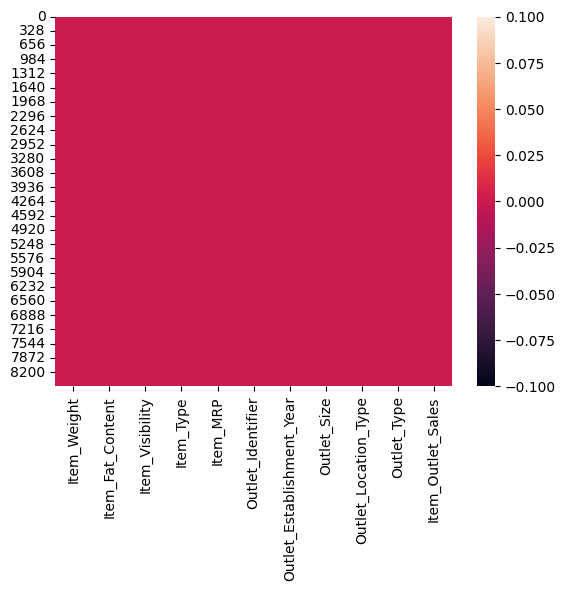

In [13]:
sns.heatmap(df.isnull())

In [14]:
from sklearn.preprocessing import LabelEncoder,StandardScaler
scaler = StandardScaler()
encoder = LabelEncoder()

In [15]:
cat_features = []
for j in df.columns:
    if df[j].dtypes=='object':
        cat_features.append(j)


In [16]:
cat_features

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [17]:
for i in df[cat_features]:
    print(">>",i,"-------------------------------------")
    
    print(df[i].unique())
    print("Total counts of",i,"is:",len(df[i].unique()),"\n")
    

>> Item_Fat_Content -------------------------------------
['Low Fat' 'Regular']
Total counts of Item_Fat_Content is: 2 

>> Item_Type -------------------------------------
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Total counts of Item_Type is: 16 

>> Outlet_Identifier -------------------------------------
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
Total counts of Outlet_Identifier is: 10 

>> Outlet_Size -------------------------------------
['Medium' 'Small' 'High']
Total counts of Outlet_Size is: 3 

>> Outlet_Location_Type -------------------------------------
['Tier 1' 'Tier 3' 'Tier 2']
Total counts of Outlet_Location_Type is: 3 

>> Outlet_Type -------------------------------------
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']
T

In [18]:
for i in df[cat_features]:
    df[i] = encoder.fit_transform(df[i])

In [19]:
num_features = []
for j in df.columns:
    if j not in cat_features:
        num_features.append(j)

In [20]:
num_features

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

In [21]:
x = pd.concat([df[num_features],df[cat_features]],axis=1)
x

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,9.300,0.016047,249.8092,1999,3735.1380,0,4,9,1,0,1
1,5.920,0.019278,48.2692,2009,443.4228,1,14,3,1,2,2
2,17.500,0.016760,141.6180,1999,2097.2700,0,10,9,1,0,1
3,19.200,0.000000,182.0950,1998,732.3800,1,6,0,2,2,0
4,8.930,0.000000,53.8614,1987,994.7052,0,9,1,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865,0.056783,214.5218,1987,2778.3834,0,13,1,0,2,1
8519,8.380,0.046982,108.1570,2002,549.2850,1,0,7,2,1,1
8520,10.600,0.035186,85.1224,2004,1193.1136,0,8,6,2,1,1
8521,7.210,0.145221,103.1332,2009,1845.5976,1,13,3,1,2,2


In [22]:
x=df.drop(columns=['Item_Outlet_Sales'],axis=1)
x

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,9.300,0,0.016047,4,249.8092,9,1999,1,0,1
1,5.920,1,0.019278,14,48.2692,3,2009,1,2,2
2,17.500,0,0.016760,10,141.6180,9,1999,1,0,1
3,19.200,1,0.000000,6,182.0950,0,1998,2,2,0
4,8.930,0,0.000000,9,53.8614,1,1987,0,2,1
...,...,...,...,...,...,...,...,...,...,...
8518,6.865,0,0.056783,13,214.5218,1,1987,0,2,1
8519,8.380,1,0.046982,0,108.1570,7,2002,2,1,1
8520,10.600,0,0.035186,8,85.1224,6,2004,2,1,1
8521,7.210,1,0.145221,13,103.1332,3,2009,1,2,2


In [23]:
x = scaler.fit_transform(x)
x.shape

(8523, 10)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((6818, 10), (1705, 10))

In [25]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [26]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 1216.8567
- Mean Absolute Error: 915.4170
- R2 Score: 0.4994
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1141.9560
- Mean Absolute Error: 855.5818
- R2 Score: 0.5202


Lasso
Model performance for Training set
- Root Mean Squared Error: 1216.8616
- Mean Absolute Error: 915.3147
- R2 Score: 0.4994
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1141.8557
- Mean Absolute Error: 855.5081
- R2 Score: 0.5203


Ridge
Model performance for Training set
- Root Mean Squared Error: 1216.8567
- Mean Absolute Error: 915.4078
- R2 Score: 0.4994
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1141.9600
- Mean Absolute Error: 855.5803
- R2 Score: 0.5202


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 974.9443
- Mean Absolute Error: 689.1898
- R2 Sco

In [27]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
7,CatBoosting Regressor,0.591663
5,Random Forest Regressor,0.562122
6,XGBRegressor,0.532701
3,K-Neighbors Regressor,0.529406
1,Lasso,0.520291
0,Linear Regression,0.520207
2,Ridge,0.520203
8,AdaBoost Regressor,0.446573
4,Decision Tree,0.179510


In [ ]:
# Catboosting

In [28]:
model = CatBoostRegressor()
model = model.fit(X_train,y_train)
y_pred = model.predict(X_test)
accuracy = r2_score(y_test,y_pred)
print(f"Accuracy: {accuracy}")

Learning rate set to 0.055449
0:	learn: 1671.4035690	total: 4.1ms	remaining: 4.09s
1:	learn: 1622.1894079	total: 7.08ms	remaining: 3.53s
2:	learn: 1578.8238359	total: 12ms	remaining: 3.98s
3:	learn: 1538.3162365	total: 16.3ms	remaining: 4.06s
4:	learn: 1499.8560735	total: 18.3ms	remaining: 3.64s
5:	learn: 1463.9123425	total: 20.9ms	remaining: 3.45s
6:	learn: 1431.0703800	total: 23.7ms	remaining: 3.36s
7:	learn: 1402.3983126	total: 25.6ms	remaining: 3.18s
8:	learn: 1374.3518246	total: 28.3ms	remaining: 3.11s
9:	learn: 1349.1266228	total: 29.9ms	remaining: 2.96s
10:	learn: 1325.7431658	total: 31.6ms	remaining: 2.84s
11:	learn: 1304.1222216	total: 33.2ms	remaining: 2.74s
12:	learn: 1284.8863075	total: 34.8ms	remaining: 2.64s
13:	learn: 1267.6163141	total: 36.4ms	remaining: 2.56s
14:	learn: 1250.4984778	total: 38.1ms	remaining: 2.5s
15:	learn: 1234.9415378	total: 39.7ms	remaining: 2.44s
16:	learn: 1221.2799670	total: 41.3ms	remaining: 2.39s
17:	learn: 1209.1050990	total: 42.8ms	remaining: 

In [29]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
7503,1743.0644,1086.620314,656.444086
2957,356.8688,874.538559,-517.669759
7031,377.5086,735.683950,-358.175350
1084,5778.4782,4757.852369,1020.625831
856,2356.9320,3038.636397,-681.704397
...,...,...,...
7205,3004.0896,1913.359784,1090.729816
3257,890.8404,2106.602272,-1215.761872
6346,629.1810,725.350666,-96.169666
6318,253.0040,643.741186,-390.737186
